In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import seaborn as sns
from pipeline import Pipeline

In [12]:
df_train = pd.read_csv("./data/train.csv")
df_valid = pd.read_csv("./data/valid.csv")

In [13]:
df_train, train_scale = Pipeline.process(data=df_train)
df_valid, valid_scale = Pipeline.process(data=df_valid)

<AxesSubplot:>

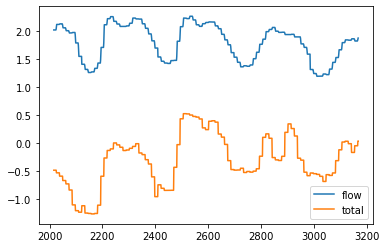

In [14]:
df_train[["flow", "total"]].iloc[: 12 * 24 * 4].plot()

In [16]:
df_test = df_valid[len(df_valid)//2:]
df_valid = df_valid[:len(df_valid)//2]

In [19]:
df_train.columns

Index(['start_time', 'hydro', 'micro', 'thermal', 'wind', 'total', 'y',
       'sys_reg', 'flow', 'time_of_day', 'time_of_week', 'time_of_year',
       'previous_y', 'prev_day_y', 'prev_week_y'],
      dtype='object')

In [91]:
k = 50
# features=['hydro', 'micro', 'previous_y']
features=['hydro', 'micro', 'thermal', 'wind', 'total',
       'sys_reg', 'flow', 'time_of_day', 'time_of_week', 'time_of_year',
        'prev_day_y', 'prev_week_y','previous_y']

In [78]:
no_features = len(features)

In [92]:
input_layer = keras.Input(shape=(k, no_features))

x = layers.LSTM(50, return_sequences=True)(input_layer)
x = layers.Dropout(0.1)(x)
x = layers.LSTM(50)(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(100, activation='relu')(x)

output_layer = layers.Dense(1, activation='linear')(x)

model = keras.Model(input_layer, output_layer, name='LSTM_Model')

In [93]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.MeanSquaredError()
)
model.summary()


Model: "LSTM_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input layer (InputLayer)    [(None, 50, 13)]          0         
                                                                 
 lstm_10 (LSTM)              (None, 50, 50)            12800     
                                                                 
 dropout_4 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 100)               5100      
                                                                 
 dense_7 (Dense)             (None, 1)                 1

In [158]:
x_train, y_train = Pipeline.format_data(df_train, k=k, features=features, drop_prev_no=0)
x_valid, y_valid = Pipeline.format_data(df_valid, k=k, features=features)
x_test, y_test = Pipeline.format_data(df_test, k=k, features=features)

In [95]:
history = model.fit(x=x_train, y=y_train, epochs=10, batch_size=128, validation_data=(x_valid, y_valid) )

Epoch 1/10
1743/1743 [==============================] - 41s 18ms/step - loss: 0.0513 - val_loss: 0.2933
Epoch 2/10
1743/1743 [==============================] - 33s 19ms/step - loss: 0.0191 - val_loss: 0.3068
Epoch 3/10
1743/1743 [==============================] - 29s 17ms/step - loss: 0.0166 - val_loss: 0.3123
Epoch 4/10
1743/1743 [==============================] - 28s 16ms/step - loss: 0.0148 - val_loss: 0.3040
Epoch 5/10
1743/1743 [==============================] - 28s 16ms/step - loss: 0.0140 - val_loss: 0.2811
Epoch 6/10
1743/1743 [==============================] - 28s 16ms/step - loss: 0.0133 - val_loss: 0.3301
Epoch 7/10
1743/1743 [==============================] - 28s 16ms/step - loss: 0.0125 - val_loss: 0.2621
Epoch 8/10
1743/1743 [==============================] - 28s 16ms/step - loss: 0.0123 - val_loss: 0.2991
Epoch 9/10
1743/1743 [==============================] - 28s 16ms/step - loss: 0.0117 - val_loss: 0.3169
Epoch 10/10
1743/1743 [==============================] - 30s 17m

In [83]:
history.history

{'loss': [0.5167571306228638,
  0.3561338186264038,
  0.3765653371810913,
  0.3687033951282501,
  0.4527599513530731,
  0.4676695168018341,
  0.428517609834671,
  0.4197126626968384,
  0.4284799098968506,
  0.4569880962371826],
 'val_loss': [3.027130365371704,
  2.786651849746704,
  1.2777888774871826,
  1.3957077264785767,
  1.380833387374878,
  1.528354287147522,
  1.3651069402694702,
  1.5202507972717285,
  1.568866491317749,
  1.592056393623352]}

In [99]:
y_pred = model.predict(x_valid)

In [235]:
model.save("./models/v0")

ValueError: Got non-flat/non-unique argument names for SavedModel signature 'serving_default': more than one argument to '__inference_signature_wrapper_842121' was named 'Input layer'. Signatures have one Tensor per named input, so to have predictable names Python functions used to generate these signatures should avoid *args and Tensors in nested structures unless unique names are specified for each. Use tf.TensorSpec(..., name=...) to provide a name for a Tensor input.

In [97]:
y_pred.shape

(223022, 1)

In [86]:
t = range(len(y_pred))

<AxesSubplot:>

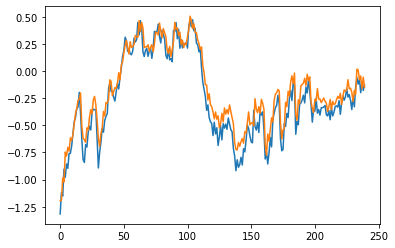

In [100]:
sns.lineplot(x=t[0:240], y=y_valid[0:240])
sns.lineplot(x=t[0:240], y=y_pred[:,0][0:240])

In [232]:
w = 1750

In [228]:
L = 100

In [233]:
preds = np.zeros(L+w)
x_t = x_test.copy()
# model(x_test[:w])
for i in range(L):
    p = model(x_t[w+i:w+i+1])[0][0]

    for j in range(i,i+k):
        x_t[w+j+1][-(1+j-i)][-1] = p
    preds[w+i]=p


In [196]:
(x_test == x_t).all()

False

In [130]:

model(x_train[w:w+1])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.3621021]], dtype=float32)>

<AxesSubplot:>

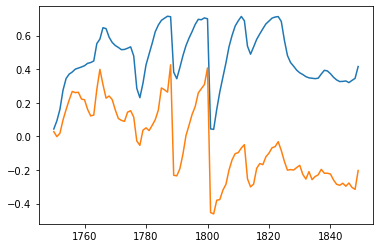

In [234]:
sns.lineplot(x=t[w:w+L], y=preds[w:w+L])
sns.lineplot(x=t[w:w+L], y=y_test[w:w+L])

In [ ]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [4]:


d,s = Pipeline.process(df)

In [6]:
features=['hydro', 'previous_y']

In [11]:
a,b = Pipeline.format_data(d, 5, features=features)

In [9]:
d[features].to_numpy().shape

(223072, 2)

In [15]:
a.shape

(223067, 5, 2)

In [16]:
b.shape

(223067,)